# Identifying tag variants
This notebook demonstrates identifying tag variants using linkage disequilibrium (LD) data stored as publicly accessible BigQuery datasets. Specifically, we will work with LD calculated on the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) variants. The source variants were imported to Google Genomics and then LD calculations were performed and the resulting dataset exported to BigQuery using pipelines in the https://github.com/googlegenomics/linkage-disequilibrium project.

If you want to explore more linkage disequilibrium samples, see https://github.com/googlegenomics/linkage-disequilibrium/tree/master/datalab. For general genomics examples, see https://github.com/googlegenomics/datalab-examples. You can import them into your Datalab instance by uploading them while on the notebook list page.

In [263]:
import gcp.bigquery as bq
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

The [initial LD exploration Datalab](https://github.com/googlegenomics/linkage-disequilibrium/blob/master/datalab/Exploring_Linkage_Disequilibrium_Data.ipynb) indicated that LD is best analyzed on a population-specific level. Consequently, we load data for subpopulations directly.

In [264]:
# Get references to the BigQuery tables of linkage disequilibrium
# in the five superpopulations of the 1000 Genomes Project
# (http://www.1000genomes.org/faq/which-populations-are-part-your-study):
# AMR: Admixed American
# AFR: African
# EUR: European
# SAS: South Asian
# EAS: East Asian
populations = {
  "AFR": ["ACB", "ASW", "ESN", "GWD", "LWK", "MSL", "YRI"],
  "AMR": ["CLM", "MXL", "PEL", "PUR"],
  "EAS": ["CDX", "CHB", "CHS", "JPT", "KHV"],
  "EUR": ["CEU", "FIN", "GBR", "IBS", "TSI"],
  "SAS": ["BEB", "GIH", "ITU", "PJL", "STU"],
}
sub_to_super = {sub: super for super, subs in populations.items() for sub in subs}

def get_ld_tablename(population):
  """Returns the name of the BigQuery table with the publicly-available LD data."""
  #return "genomics-public-data:linkage_disequilibrium_1000G_phase_3.%s" % population
  return "genomics-pipelines:linkage_disequilibrium_1000G_phase_3.lactase_sub_%s" % population

tables = {}
for superpopulation in populations:
  subpopulations = populations[superpopulation]
  
  for subpopulation in subpopulations:
    # Only load the subpopulations for this analysis.
    tables[subpopulation] = bq.Table(get_ld_tablename(subpopulation))

## Identifying variants that "tag" variants of interest
A major use case for LD data is to identify variants that capture the same underlying information. For example, an individual who has been genotyped using a [DNA microarray](https://en.wikipedia.org/wiki/DNA_microarray) will only have information at a subset of all variant sites in the genome. However, there are many variant sites that have some known phenotypic consequences. For instance, the variant [rs4988235](http://www.snpedia.com/index.php/Rs4988235) is known to be associated with lactase persistence. An individual who has been genotyped on a microarray that does not directly assay rs4988235 may still be able to infer their likely genotype at that SNP by using LD.

The following BigQuery query will identify variants that may be usable as proxies for a specified input variant of interest.

In [265]:
%%sql --module proxy_variant_query
SELECT
  qname,
  qzeroallele,
  qoneallele,
  tchrom,
  tstart,
  tname,
  tzeroallele,
  toneallele,
  ABS(tstart - qstart) AS distance,
  corr * corr AS rsquared
FROM
  $all_ld_table
WHERE
  qname == $query_rsid AND
  corr * corr >= $min_rsq AND
  ABS(tstart - qstart) <= $max_distance
ORDER BY rsquared DESC, distance
LIMIT 30

In [266]:
lactase_rsid = "rs4988235"
table = tables["CEU"]  # For a European individual
lactase_tag_variants = bq.Query(proxy_variant_query,
                                all_ld_table=table,
                                query_rsid=lactase_rsid,
                                min_rsq=0.8,
                                max_distance=500000).to_dataframe()
lactase_tag_variants

,qname,qzeroallele,qoneallele,tchrom,tstart,tname,tzeroallele,toneallele,distance,rsquared
0,rs4988235,G,A,2,136616753,rs182549,C,T,8108,1.000000
1,rs4988235,G,A,2,136429365,rs62168795,T,C,179280,0.926027
2,rs4988235,G,A,2,136381347,rs12465802,G,A,227298,0.903131
3,rs4988235,G,A,2,136707981,rs6754311,T,C,99336,0.897787
4,rs4988235,G,A,2,136352326,rs74775210,T,TTC,256319,0.859707
5,rs4988235,G,A,2,136611302,rs55820219,G,GA,2657,0.849697
6,rs4988235,G,A,2,136328889,rs56369224,A,T,279756,0.839100
7,rs4988235,G,A,2,136617804,rs160329,C,T,9159,0.802198


As the result shows, there are eight target variants that are in strong LD with the lactase persistence-associated rs4988235, including rs182549 that is in perfect LD in the CEU population.

## Tag variant rates
We can generalize the above query to investigate the average number of tag variants for each query variant as a function of distance between variants, in a manner similar to that performed in [Figure 4b](http://www.nature.com/nature/journal/v526/n7571/fig_tab/nature15393_F4.html) of the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) paper.

This analysis is performed in multiple stages. The first stage uses the below query to identify the total number of variants in the data set that fall within the specific minor allele frequency range of interest.

In [267]:
%%sql --module maf_variant_counts
SELECT EXACT_COUNT_DISTINCT(qid) AS num_variants
FROM $all_ld_table
WHERE
  LEAST(num_qone_chroms / num_chroms, (num_chroms - num_qone_chroms) / num_chroms) >= $min_maf AND
  LEAST(num_qone_chroms / num_chroms, (num_chroms - num_qone_chroms) / num_chroms) < $max_maf

This next query is used to count the total number of variant pairs at each distance bin that satisfy the correlation threshold.

In [268]:
%%sql --module tag_variation_query
SELECT
  INTEGER(CEIL((tstart - qstart) / $bin_size)) AS distance,
  INTEGER(COUNT(*)) AS num_tag_variants
FROM $all_ld_table
WHERE
  qstart < tstart AND
  (corr * corr) >= $min_rsq AND
  LEAST(num_qone_chroms / num_chroms, (num_chroms - num_qone_chroms) / num_chroms) >= $min_maf AND
  LEAST(num_qone_chroms / num_chroms, (num_chroms - num_qone_chroms) / num_chroms) < $max_maf AND
  tstart - qstart <= $max_dist
GROUP BY distance
ORDER BY distance

The average number of cumulative variant pairs at each distance bin is calculated by taking the running sum over all individual distance bins:

In [269]:
# Create a dictionary keyed by population with value a DataFrame of r^2 values
# binned by distance from the query variant.
tag_variation = {}
binsize = 5000
maxdist = 1000000
for mafbin, minmaf, maxmaf in [("Rare", 0, 0.005),
                               ("Low frequency", 0.005, 0.05),
                               ("Common", 0.05, 1)]:
  tag_variation[mafbin] = {}
  for population, table in tables.iteritems():
    # Find the total number of variants in this MAF range.
    varcount_query = bq.Query(maf_variant_counts,
                              all_ld_table=table,
                              min_maf=minmaf,
                              max_maf=maxmaf).to_dataframe()
    num_maf_variants = varcount_query["num_variants"][0]
    
    # Find the total number of pairs of strong LD at each bin size.
    result = bq.Query(tag_variation_query,
                      all_ld_table=table,
                      bin_size=binsize,
                      min_maf=minmaf,
                      max_maf=maxmaf,
                      max_dist=maxdist,
                      min_rsq=0.8).to_dataframe()
    if len(result.columns):
      # Scale the bins back up to distances.
      result["distance"] *= bin_size
      # Transform the counts to averages of cumulative counts.
      result["avg_tag_variants"] = result["num_tag_variants"].cumsum() / float(num_maf_variants)
      tag_variation[mafbin][population] = result
    else:
      # There are no results. Create an empty DataFrame with the same columns.
      tag_variation[mafbin][population] = pd.DataFrame({"distance": [],
                                                        "num_tag_variants": [],
                                                        "cumul_tag_variants": [],
                                                        "avg_tag_variants": []})

The following function is used to display the tag variation results.

In [270]:
def plot_tag_variation(tag_variation_dict, max_distance=200000):
  """Plots a figure of tag variation in all populations."""
  fig = plt.figure()
  ax = fig.add_subplot(111)
  handles = []
  colormaps = {"AFR": matplotlib.cm.get_cmap("YlOrBr"),
               "AMR": matplotlib.cm.get_cmap("Reds"),
               "EAS": matplotlib.cm.get_cmap("Greens"),
               "EUR": matplotlib.cm.get_cmap("Blues"),
               "SAS": matplotlib.cm.get_cmap("Purples")}
  
  # Plot data so that the legend groups by superpopulation,
  # ordered from the highest to lowest LD.
  pop_order = [sub_to_super[k] for k, v in sorted(tag_variation_dict.items(),
                                                  key=lambda x: x[1]["avg_tag_variants"].max(),
                                                  reverse=True)]

  population_plot_order = []
  for superpop in pop_order:
    if superpop not in population_plot_order:
      population_plot_order.append(superpop)
  
  labels = []
  for superpopulation in population_plot_order:
    subpopulations = populations[superpopulation]
    for i, subpopulation in enumerate(subpopulations):
      df = tag_variation_dict[subpopulation]
      df = df.loc[df["distance"] <= max_distance]
      if not len(df["distance"]):
        continue
      color = colormaps[superpopulation](1 - (i / 8.))
      lp, = ax.plot(df["distance"], df["avg_tag_variants"],
                    label=subpopulation,
                    color=color)
                   
      handles.append(lp)
      labels.append(subpopulation)
  plt.legend(handles, labels,
             loc='center left',
             bbox_to_anchor=(1.1, 0.5))
  ax.set_axis_bgcolor("white")
  ax.grid(False)
  ax.set_xlabel("Distance (bp)")
  ax.set_ylabel("Average number of tag variants")

Now we can plot the average number of tag variants per query variant as a function of distance from the query variant:

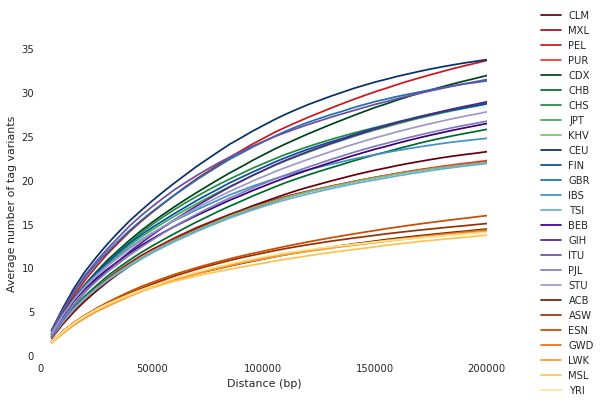

In [271]:
plot_tag_variation(tag_variation["Common"])

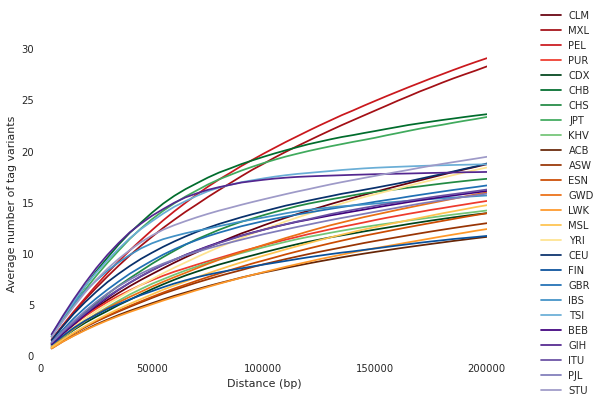

In [272]:
plot_tag_variation(tag_variation["Low frequency"])

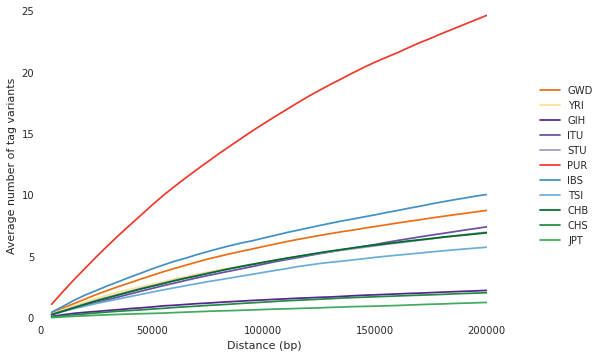

In [273]:
plot_tag_variation(tag_variation["Rare"])

Other LD metrics [showed substantial differences](https://github.com/googlegenomics/linkage-disequilibrium/blob/master/datalab/Exploring_Linkage_Disequilibrium_Data.ipynb) when analyzed on the superpopulation level compared to subpopulation level. In contrast, the plots are very similar to the superpopulation-based plots made in the 1000 Genomes paper [Figure 4b](http://www.nature.com/nature/journal/v526/n7571/fig_tab/nature15393_F4.html), with the African populations showing much less average tag variation than the other populations.

This similarity may be due in part to a lesser impact of population stratification on patterns of extremely strong LD.